📓 Notebook: Brain Tumor Classification using Vision Transformer (ViT)


In [ ]:
import os
import numpy as np
import cv2
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
# --- 1. Configuration & Setup ---
# Download the dataset from Kaggle
print("Downloading dataset from Kaggle Hub...")
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print(f"Dataset downloaded to: {path}")

# Define paths
DATA_DIR = path
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
TEST_DIR = os.path.join(DATA_DIR, 'Testing')

# Model & Image Configuration
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8 # Further reduced batch size
INPUT_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1) # Grayscale images
NUM_CLASSES = 4
CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']

# ViT Hyperparameters
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE[0] // PATCH_SIZE) ** 2
PROJECTION_DIM = 768
NUM_HEADS = 12
TRANSFORMER_UNITS = [PROJECTION_DIM * 4, PROJECTION_DIM]
TRANSFORMER_LAYERS = 8
MLP_HEAD_UNITS = [2048, 1024]

Dataset downloaded to: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
# --- 2. Data Loading and Preprocessing ---

def load_and_preprocess_data(directory, augment=True):
    """
    Loads images from subdirectories, applies preprocessing, and optional augmentation.

    Args:
        directory (str): Path to the data directory (e.g., 'Training' or 'Testing').
        augment (bool): Whether to apply horizontal flip augmentation.

    Returns:
        tuple: A tuple containing lists of images and their corresponding labels.
    """
    images = []
    labels = []

    print(f"\nLoading and preprocessing data from: {directory}")
    for label_idx, class_name in enumerate(CLASS_NAMES):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            print(f"Warning: Directory not found: {class_dir}")
            continue

        print(f"  - Loading class: {class_name}")
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)

            # Read image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"    Warning: Could not read image: {img_path}")
                continue

            # Resize image
            img_resized = cv2.resize(img, IMAGE_SIZE)

            # Apply Histogram Equalization
            img_equalized = cv2.equalizeHist(img_resized)

            # Add preprocessed image
            images.append(img_equalized)
            labels.append(label_idx)

            # Augment with horizontal flip
            if augment:
                img_flipped = cv2.flip(img_equalized, 1)
                images.append(img_flipped)
                labels.append(label_idx)

    images = np.array(images)
    # Add channel dimension for CNN compatibility
    images = np.expand_dims(images, -1)
    labels = np.array(labels)

    # Normalize pixel values
    images = images.astype('float32') / 255.0

    return images, labels

# Load the data
X_train, y_train = load_and_preprocess_data(TRAIN_DIR, augment=True)
X_test, y_test = load_and_preprocess_data(TEST_DIR, augment=False)

print(f"\nTraining data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")



Loading and preprocessing data from: /kaggle/input/brain-tumor-mri-dataset/Training
  - Loading class: glioma
  - Loading class: meningioma
  - Loading class: notumor
  - Loading class: pituitary

Loading and preprocessing data from: /kaggle/input/brain-tumor-mri-dataset/Testing
  - Loading class: glioma
  - Loading class: meningioma
  - Loading class: notumor
  - Loading class: pituitary

Training data shape: (11424, 224, 224, 1), Labels shape: (11424,)
Testing data shape: (1311, 224, 224, 1), Labels shape: (1311,)



Displaying preprocessing example...


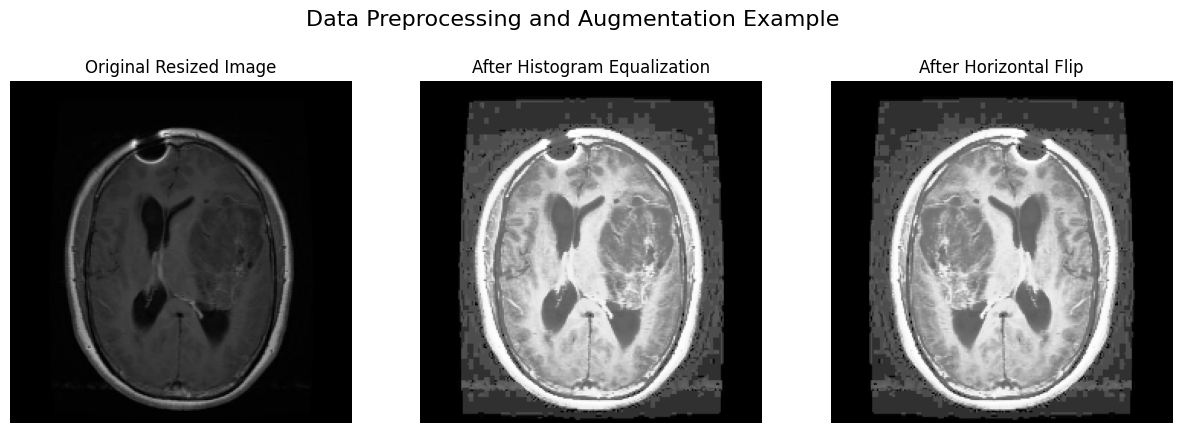

In [ ]:
# --- 3. Visualize Preprocessing ---
def show_preprocessing_example():
    """Shows a visual example of the preprocessing steps."""
    print("\nDisplaying preprocessing example...")
    # Find a sample image
    sample_path = os.path.join(TRAIN_DIR, 'glioma', os.listdir(os.path.join(TRAIN_DIR, 'glioma'))[5])

    # Original
    original_img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    original_img_resized = cv2.resize(original_img, IMAGE_SIZE)

    # Histogram Equalized
    equalized_img = cv2.equalizeHist(original_img_resized)

    # Flipped
    flipped_img = cv2.flip(equalized_img, 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img_resized, cmap='gray')
    plt.title('Original Resized Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(equalized_img, cmap='gray')
    plt.title('After Histogram Equalization')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(flipped_img, cmap='gray')
    plt.title('After Horizontal Flip')
    plt.axis('off')

    plt.suptitle("Data Preprocessing and Augmentation Example", fontsize=16)
    plt.show()

show_preprocessing_example()

In [ ]:
# --- 4. Vision Transformer (ViT) Implementation ---

# 4.1. Patch Creation Layer
class Patches(layers.Layer):
    """Extracts patches from an image."""
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# 4.2. Patch Encoder Layer (with Positional Embedding)
class PatchEncoder(layers.Layer):
    """Encodes patches with a projection and adds position embedding."""
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# 4.3. Build the ViT Model
def create_vit_classifier():
    """Creates the complete Vision Transformer model."""
    inputs = layers.Input(shape=INPUT_SHAPE)

    # Create patches
    patches = Patches(PATCH_SIZE)(inputs)

    # Encode patches
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = layers.Dense(TRANSFORMER_UNITS[0], activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(0.1)(x3)
        x3 = layers.Dense(TRANSFORMER_UNITS[1], activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(0.1)(x3)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Add MLP.
    features = layers.Dense(MLP_HEAD_UNITS[0], activation=tf.nn.gelu)(representation)
    features = layers.Dropout(0.5)(features)
    features = layers.Dense(MLP_HEAD_UNITS[1], activation=tf.nn.gelu)(features)

    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES, activation="softmax")(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
# --- 5. Model Training ---
print("\nBuilding the Vision Transformer model...")
vit_classifier = create_vit_classifier()
vit_classifier.summary()

# Compile the model
vit_classifier.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Create a callback for early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)


Building the Vision Transformer model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 256) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 196, 768)  │    347,904 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 768)  │      1,536 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 768)  │ 28,339,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 768)  │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 768)  │      1,536 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 196, 3072) │  2,362,368 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 196, 3072) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 196, 768)  │  2,360,064 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 196, 768)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 768)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 768)  │      1,536 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 768)  │ 28,339,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 768)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 768)  │      1,536 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 196, 3072) │  2,362,368 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 196, 3072) │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 196, 768)  │  2,360,064 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 575,258,884 (2.14 GB)

 Trainable params: 575,258,884 (2.14 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
print("\nStarting model training...")
history = vit_classifier.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=10, # Set a higher number, early stopping will find the best epoch
    validation_split=0.2, # Use part of the training data for validation
    callbacks=[early_stopping],
)


Starting model training...
Epoch 1/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 680s 544ms/step - accuracy: 0.4684 - loss: 4.0821 - val_accuracy: 0.0000e+00 - val_loss: 2.8977
Epoch 2/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 577s 505ms/step - accuracy: 0.7673 - loss: 0.6015 - val_accuracy: 0.2420 - val_loss: 1.7401
Epoch 3/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 577s 505ms/step - accuracy: 0.7789 - loss: 0.5586 - val_accuracy: 0.6473 - val_loss: 1.2787
Epoch 4/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 577s 505ms/step - accuracy: 0.8160 - loss: 0.4757 - val_accuracy: 0.7392 - val_loss: 1.0772
Epoch 5/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 576s 504ms/step - accuracy: 0.8085 - loss: 0.4731 - val_accuracy: 0.4919 - val_loss: 1.5712
Epoch 6/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 577s 504ms/step - accuracy: 0.8156 - loss: 0.4563 - val_accuracy: 0.7751 - val_loss: 1.1530
Epoch 7/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 577s 504ms/step - accuracy: 0.8259 - loss: 0.4299 - val_accuracy: 0.3694 - val_loss: 2.0038
Epoch 8/10
1143/1143 ━━━━━━━━━


Plotting training history...


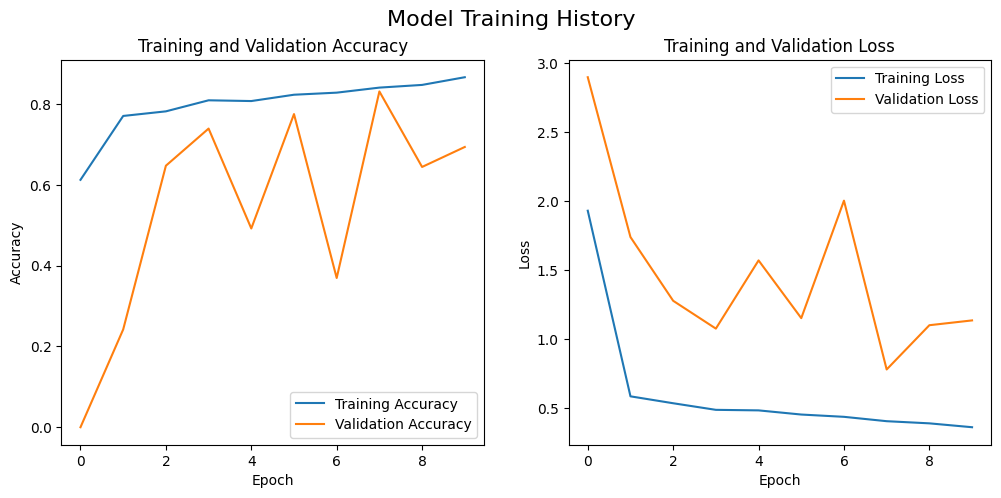

In [ ]:
# --- 6. Evaluation and Visualization ---

# 6.1. Plot Training History
def plot_history(history):
    """Plots accuracy and loss curves for training and validation."""
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle("Model Training History", fontsize=16)
    plt.show()

print("\nPlotting training history...")
plot_history(history)

In [ ]:
# 6.2. Evaluate on Test Set
print("\nEvaluating model on the test set...")
loss, accuracy = vit_classifier.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")


Evaluating model on the test set...
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.7818 - loss: 0.4993
Test Accuracy: 0.8162
Test Loss: 0.4986


In [ ]:
# 6.3. Save the Model
print("\nSaving the trained model...")
model_save_path = "brain_tumor_vit_model.keras"
vit_classifier.save(model_save_path)
print(f"Model saved to: {os.path.abspath(model_save_path)}")


Saving the trained model...
Model saved to: /content/brain_tumor_vit_model.keras



Generating classification report and confusion matrix...
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 345ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.84      0.83      0.84       300
  meningioma       0.66      0.55      0.60       306
     notumor       0.81      1.00      0.89       405
   pituitary       0.95      0.83      0.88       300

    accuracy                           0.82      1311
   macro avg       0.82      0.80      0.80      1311
weighted avg       0.81      0.82      0.81      1311



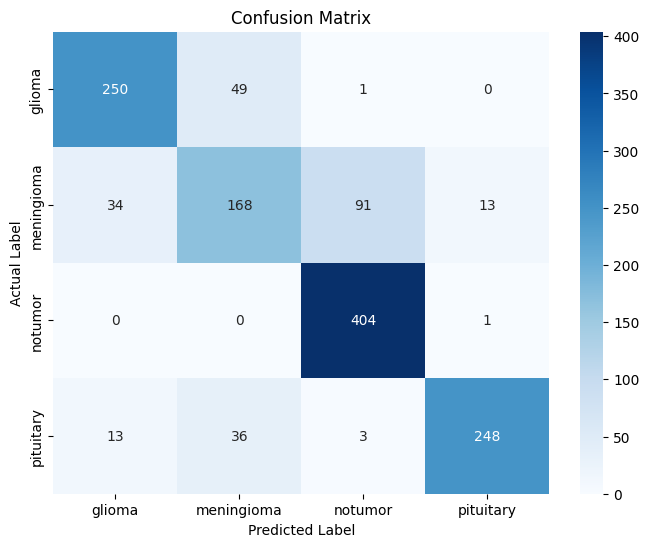


--- Script Finished ---


In [ ]:
# 6.4. Confusion Matrix and Classification Report
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plots a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("\nGenerating classification report and confusion matrix...")
y_pred_probs = vit_classifier.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=CLASS_NAMES))

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_classes, CLASS_NAMES)

print("\n--- Script Finished ---")




--- Continuing Training for 5 More Epochs ---
Epoch 1/5
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 578s 505ms/step - accuracy: 0.8440 - loss: 0.3964 - val_accuracy: 0.8039 - val_loss: 0.8992
Epoch 2/5
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 577s 505ms/step - accuracy: 0.8612 - loss: 0.3704 - val_accuracy: 0.9470 - val_loss: 0.6790
Epoch 3/5
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 577s 505ms/step - accuracy: 0.8702 - loss: 0.3458 - val_accuracy: 0.8600 - val_loss: 0.7945
Epoch 4/5
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 577s 505ms/step - accuracy: 0.8830 - loss: 0.3057 - val_accuracy: 0.6902 - val_loss: 1.0810
Epoch 5/5
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 577s 505ms/step - accuracy: 0.8847 - loss: 0.3162 - val_accuracy: 0.7072 - val_loss: 1.1055

Saving the model after extra training...


Model saved to: /content/brain_tumor_vit_model_5extra.keras
Model saved to: /content/brain_tumor_vit_model_5extra.h5

Re-evaluating model on the test set after extra training...
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.7872 - loss: 0.4487
Test Accuracy after extra training: 0.8230
Test Loss after extra training: 0.4877

Generating new classification report and confusion matrix...
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 272ms/step

Classification Report after extra training:
              precision    recall  f1-score   support

      glioma       0.93      0.77      0.84       300
  meningioma       0.66      0.73      0.69       306
     notumor       0.81      1.00      0.89       405
   pituitary       0.99      0.74      0.85       300

    accuracy                           0.82      1311
   macro avg       0.85      0.81      0.82      1311
weighted avg       0.84      0.82      0.82      1311



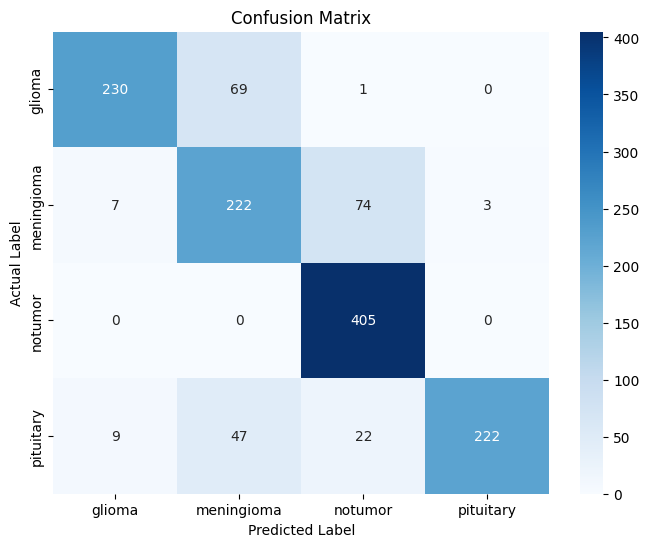


--- Script Finished ---


In [ ]:
# --- 7. Continue Training and Re-evaluate ---

print("\n\n--- Continuing Training for 5 More Epochs ---")
history_extra = vit_classifier.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=5, # Train for 5 more epochs
    validation_split=0.2,
)

print("\nSaving the model after extra training...")
model_save_path_keras = "brain_tumor_vit_model_5extra.keras"
model_save_path_h5 = "brain_tumor_vit_model_5extra.h5"

vit_classifier.save(model_save_path_keras)
vit_classifier.save(model_save_path_h5)

print(f"Model saved to: {os.path.abspath(model_save_path_keras)}")
print(f"Model saved to: {os.path.abspath(model_save_path_h5)}")

# Re-evaluate the model on the test set
print("\nRe-evaluating model on the test set after extra training...")
loss_extra, accuracy_extra = vit_classifier.evaluate(X_test, y_test)
print(f"Test Accuracy after extra training: {accuracy_extra:.4f}")
print(f"Test Loss after extra training: {loss_extra:.4f}")

# Generate a new classification report and confusion matrix
print("\nGenerating new classification report and confusion matrix...")
y_pred_probs_extra = vit_classifier.predict(X_test)
y_pred_classes_extra = np.argmax(y_pred_probs_extra, axis=1)

print("\nClassification Report after extra training:")
print(classification_report(y_test, y_pred_classes_extra, target_names=CLASS_NAMES))

plot_confusion_matrix(y_test, y_pred_classes_extra, CLASS_NAMES)


print("\n--- Script Finished ---")
